## #Please change paths to the according pointing on your system

In [43]:
import os
from pathlib import Path
import h5py
import warnings
import tables
import calendar

import torch
import scipy
from scipy.spatial.distance import pdist, cdist
from scipy import stats
from tqdm import tqdm

import os
os.environ["OMP_NUM_THREADS"] = '3'
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [31]:
#file_name = '20231103_OM_privat_short.csv'
file_name = 'onlyClusterIDSynthDDPM.csv'

#folder_path = 'D:\\GWDG\\LSM_Challenge\\openmeter\\data\\202401_OM_data_for_training'

#file_path_os = os.path.join(folder_path, file_name)

#reading file and setting index to datetime
om_df = pd.read_csv(file_name)
om_df.index = pd.to_datetime(om_df['Unnamed: 0'].rename('Timestamp'))
om_df = om_df.drop(columns=['Unnamed: 0'])

#om_df.rename(columns={'time': 'Datetime'}, inplace=True)
#om_df['Datetime'] = pd.to_datetime(om_df['Datetime'])
#om_df.set_index('time', inplace=True)

In [32]:
om_df.head()

,/001dce72-b1c1-44b1-bf16-0c22cfe3a420,/00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d,/0252a8f5-9913-47bb-a70f-c86e5c69f71a,/02a7475b-9007-4aef-a265-b38bbdbbec32,/0358067f-cd41-4d91-ba9e-91405fbfc704,/037d3c0e-2c33-4705-a6a4-778ce0858c85,/04b1dc78-587d-4837-978e-ac288a2b480c,/06d1421b-265b-4a13-a39f-6df00dbf92a6,/0987b42a-c841-4454-90ac-69e5b1054cd5,/09f9a8ca-f346-4c9e-9ce6-8e7725bae5b3,...,/fa90c793-cba7-4cb7-baad-3b0d8358fa87,/fb191ad9-ee1a-43f7-8045-036158ca45fc,/fb534067-5a19-4800-90b4-886642fbd0ed,/fcf879e3-b960-4d3b-91eb-a7c9b7eab187,/fd440cb5-d81e-40ee-9819-8395a61c3a35,/fd53424d-2cfa-4a08-8010-98a2b1aec35f,/fe3e7a4a-1e6f-446b-9f12-86824c85d23a,/fe61333c-b60c-4500-bfa6-0b14db32d6d6,/ff029d36-1c57-43fc-922f-2c148c3f6200,/ffd9031e-4660-4018-889d-a3c1ddb65926
Timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.064303,0.033257,0.029205,0.025422,2.710476,0.034915,0.073719,0.111157,0.013982,0.079502,...,0.020112,0.172850,0.040840,0.920606,0.051029,0.093531,0.049622,0.091186,0.133883,0.009709
2019-01-01 00:15:00,0.080260,0.055346,0.013081,0.009089,2.381357,0.017383,0.012683,0.103135,-0.009876,0.052804,...,0.031872,0.155910,0.041425,0.860844,0.029362,0.089554,0.093640,0.082378,0.118270,0.023765
2019-01-01 00:30:00,0.101127,0.061699,0.009111,-0.013932,2.215312,0.012520,-0.005851,0.119596,0.012998,0.058892,...,0.022572,0.194015,0.037904,0.907883,0.007005,0.110636,0.120498,0.077920,0.168856,0.025255
2019-01-01 00:45:00,0.079512,0.035939,0.015860,0.013771,2.210073,0.021631,0.029562,0.103485,0.038222,0.072312,...,0.026376,0.262773,0.014177,0.950367,0.058079,0.096477,0.063418,0.049740,0.227130,0.079180
2019-01-01 01:00:00,0.037031,0.114258,0.002971,0.023114,1.844330,0.037087,0.091108,0.106548,0.022385,0.085259,...,0.014774,0.164804,0.038210,0.893308,0.055942,0.072555,0.111223,0.041779,0.125732,0.062344


# Data prepartion and sample generation

- with columns time,MAC_IDs.... und datetime64,kwh_hh values into a tensor for the analysis in this notebook

- Anka & Phil modified the original code from Stephan that was working with the LSM-data and we tried to get it work with the OM-data as well.
    - maybe something goes wrong here that causes problems later


In [33]:
with pd.HDFStore("FullOpenmeter-ClusterWeather-16-01.h5", mode='r') as hdf:
        keys = hdf.keys()
        print(hdf[keys[0]].keys())

Index(['w', 'sensor_id', 'cluster_id', 't2m'], dtype='object')


In [34]:
file_out = "20231306_OM.h5"

# Define your specific parameters
min_test_required = 0.5  # Adjust this value as needed
train_start_date = "2022-01-01"  # Adjust the training start date as needed
train_end_date = "2023-07-30"    # Adjust the training end date as needed
test_start_date = "2021-01-01"   # Adjust the testing start date as needed
test_end_date = "2021-12-31"     # Adjust the testing end date as needed

def filter_households(data, min_test_required=0.1):
    n_samples_test = [len(household['power_test']) for household in data]
    max_num_time_steps = max(n_samples_test)
    min_abs_required = max_num_time_steps * min_test_required
    data_filtered = [household for household, n_samples in zip(data, n_samples_test) if n_samples > min_abs_required]
    return data_filtered

def load_households_from_hdf(hdf_file, min_test_required, train_start_date, train_end_date, test_start_date, test_end_date):
    data = []
    with pd.HDFStore(hdf_file, mode='r') as hdf:
        keys = hdf.keys()

        for key_id, key in enumerate(keys):
            df = hdf.get(key)
            df['w'] = pd.to_numeric(df['w'], errors='coerce')
            df.dropna(subset=['w'], inplace=True)

            numeric_columns = ['w']
            df = df[numeric_columns]

            df.index = pd.to_datetime(df.index)
            df = df.resample('15min').mean()
            df.dropna(inplace=True)

            power_values = df['w'].values.astype(np.float32)
            time = df.index.values

            # Split data into training and testing based on custom time frames
            train_bool = (time >= np.datetime64(train_start_date)) & (time <= np.datetime64(train_end_date))
            test_bool = (time >= np.datetime64(test_start_date)) & (time <= np.datetime64(test_end_date))

            train_idx = np.where(train_bool)[0]
            test_idx = np.where(test_bool)[0]

            # Split power values into training and testing
            power_train = power_values[train_idx]
            power_test = power_values[test_idx]

            time_train = time[train_idx]
            time_test = time[test_idx]

            data.append(dict(
                key=key,
                power_train=power_train,
                power_test=power_test,
                time_train=time_train,
                time_test=time_test
            ))

        hdf.close()

    data = filter_households(data, min_test_required)
    return data

file_out = "FullOpenmeter-ClusterWeather-16-01.h5"  # Replace with the actual file path
data = load_households_from_hdf(file_out, min_test_required, train_start_date, train_end_date, test_start_date, test_end_date)
print("\nNumber of households:", len(data))


Number of households: 459


In [35]:
data

[{'key': '/001dce72-b1c1-44b1-bf16-0c22cfe3a420',
  'power_train': array([456.0879 , 706.76556, 743.34375, ..., 498.2233 , 479.71158,
         469.5167 ], dtype=float32),
  'power_test': array([923.7112 , 989.09125, 801.3238 , ..., 750.2684 , 428.04163,
         298.02533], dtype=float32),
  'time_train': array(['2022-01-01T00:00:00.000000000', '2022-01-01T00:15:00.000000000',
         '2022-01-01T00:30:00.000000000', ...,
         '2023-07-05T03:30:00.000000000', '2023-07-05T03:45:00.000000000',
         '2023-07-05T04:00:00.000000000'], dtype='datetime64[ns]'),
  'time_test': array(['2021-01-01T00:00:00.000000000', '2021-01-01T00:15:00.000000000',
         '2021-01-01T00:30:00.000000000', ...,
         '2021-12-30T23:30:00.000000000', '2021-12-30T23:45:00.000000000',
         '2021-12-31T00:00:00.000000000'], dtype='datetime64[ns]')},
 {'key': '/00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d',
  'power_train': array([182.81992, 169.23625, 164.42871, ..., 758.62976, 297.53702,
         681.4162

### OM_original data


In [36]:
file_name = '20240119_OM_privat.csv'
folder_path = 'D:\\GWDG\\LSM_Challenge\\openmeter\\data\\202401_OM_data_for_training'
file_path_os = os.path.join(folder_path, file_name)

om_df = pd.read_csv(file_path_os)
om_df.rename(columns={'time': 'Datetime'}, inplace=True)
om_df['Datetime'] = pd.to_datetime(om_df['Datetime'])
#om_df = om_df.drop(idtokick, axis=1)
#om_df.set_index('time', inplace=True)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\GWDG\\LSM_Challenge\\openmeter\\data\\202401_OM_data_for_training\\20240119_OM_privat.csv'

In [ ]:
om_df['Datetime'] = om_df['Datetime'].astype('datetime64[ns]')

om_samples = dict()

for col in om_df:
  if col != 'Datetime':
    key = f'/{col}'
    om_samples[key] = dict()
    om_samples[key]['samples'] = om_df[col].values
    om_samples[key]['times'] = om_df['Datetime'].values
    
#om_samples

### WGAN data

In [ ]:
file_name2 = 'BenBasicEmbeddingCManyToManyHybridLSTMFFWGANprivateScaled.csv'
folder_path2 = 'D:\\GWDG\LSM_Challenge\\datachallenge_NOV23\\WGAN'
file_path_os2 = os.path.join(folder_path2, file_name2)

WGAN_df = pd.read_csv(file_path_os2)
WGAN_df['Datetime'] = WGAN_df['Datetime'].astype('datetime64[ns]')

#WGAN_df = WGAN_df.drop(idtokick, axis=1)   # drop selected households from analysis
#WGAN_df

In [ ]:
WGAN_df['Datetime'] = WGAN_df['Datetime'].astype('datetime64[ns]')

WGAN_samples = dict()

for col in WGAN_df:
  if col != 'Datetime':
    key = f'/{col}'
    WGAN_samples[key] = dict()
    WGAN_samples[key]['samples'] = WGAN_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    WGAN_samples[key]['times'] = WGAN_df['Datetime'].values

#WGAN_samples

### DDPM data

In [37]:
file_name3 = 'onlyClusterIDSynthDDPM.csv'
# folder_path3 = 'D:\\GWDG\LSM_Challenge\\datachallenge_NOV23\\DDPM'
# file_path_os3 = os.path.join(folder_path3, file_name3)

ddpm_df = pd.read_csv(file_name3)
ddpm_df.columns = ddpm_df.columns.str.replace('/', '')
ddpm_df['Unnamed: 0'] = ddpm_df['Unnamed: 0'].astype('datetime64[ns]')

ddpm_df.index = pd.to_datetime(ddpm_df['Unnamed: 0'].rename('Datetime'))
ddpm_df.rename(columns={'Unnamed: 0': 'Datetime'}, inplace=True)
#ddpm_df = ddpm_df.drop(columns=['Unnamed: 0'])
#
ddpm_df.head()

,Datetime,001dce72-b1c1-44b1-bf16-0c22cfe3a420,00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d,0252a8f5-9913-47bb-a70f-c86e5c69f71a,02a7475b-9007-4aef-a265-b38bbdbbec32,0358067f-cd41-4d91-ba9e-91405fbfc704,037d3c0e-2c33-4705-a6a4-778ce0858c85,04b1dc78-587d-4837-978e-ac288a2b480c,06d1421b-265b-4a13-a39f-6df00dbf92a6,0987b42a-c841-4454-90ac-69e5b1054cd5,...,fa90c793-cba7-4cb7-baad-3b0d8358fa87,fb191ad9-ee1a-43f7-8045-036158ca45fc,fb534067-5a19-4800-90b4-886642fbd0ed,fcf879e3-b960-4d3b-91eb-a7c9b7eab187,fd440cb5-d81e-40ee-9819-8395a61c3a35,fd53424d-2cfa-4a08-8010-98a2b1aec35f,fe3e7a4a-1e6f-446b-9f12-86824c85d23a,fe61333c-b60c-4500-bfa6-0b14db32d6d6,ff029d36-1c57-43fc-922f-2c148c3f6200,ffd9031e-4660-4018-889d-a3c1ddb65926
Datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,2019-01-01 00:00:00,0.064303,0.033257,0.029205,0.025422,2.710476,0.034915,0.073719,0.111157,0.013982,...,0.020112,0.172850,0.040840,0.920606,0.051029,0.093531,0.049622,0.091186,0.133883,0.009709
2019-01-01 00:15:00,2019-01-01 00:15:00,0.080260,0.055346,0.013081,0.009089,2.381357,0.017383,0.012683,0.103135,-0.009876,...,0.031872,0.155910,0.041425,0.860844,0.029362,0.089554,0.093640,0.082378,0.118270,0.023765
2019-01-01 00:30:00,2019-01-01 00:30:00,0.101127,0.061699,0.009111,-0.013932,2.215312,0.012520,-0.005851,0.119596,0.012998,...,0.022572,0.194015,0.037904,0.907883,0.007005,0.110636,0.120498,0.077920,0.168856,0.025255
2019-01-01 00:45:00,2019-01-01 00:45:00,0.079512,0.035939,0.015860,0.013771,2.210073,0.021631,0.029562,0.103485,0.038222,...,0.026376,0.262773,0.014177,0.950367,0.058079,0.096477,0.063418,0.049740,0.227130,0.079180
2019-01-01 01:00:00,2019-01-01 01:00:00,0.037031,0.114258,0.002971,0.023114,1.844330,0.037087,0.091108,0.106548,0.022385,...,0.014774,0.164804,0.038210,0.893308,0.055942,0.072555,0.111223,0.041779,0.125732,0.062344


In [38]:

ddpm_samples = dict()

for col in ddpm_df:
  if col != 'Datetime':
    key = f'/{col}'
    ddpm_samples[key] = dict()
    ddpm_samples[key]['samples'] = ddpm_df[col].values
    #ddpm_samples[key]['times'] = ddpm_df['Datetime'].values.astype('datetime64[ns]')
    ddpm_samples[key]['times'] = ddpm_df['Datetime'].values

ddpm_samples

{'/001dce72-b1c1-44b1-bf16-0c22cfe3a420': {'samples': array([0.06430344, 0.08026031, 0.10112748, ..., 0.06255519, 0.05146596,
         0.06418766]),
  'times': array(['2019-01-01T00:00:00.000000000', '2019-01-01T00:15:00.000000000',
         '2019-01-01T00:30:00.000000000', ...,
         '2020-12-31T23:15:00.000000000', '2020-12-31T23:30:00.000000000',
         '2020-12-31T23:45:00.000000000'], dtype='datetime64[ns]')},
 '/00a3c3e4-bf1f-4c0b-9e18-8bc60e66575d': {'samples': array([0.03325716, 0.05534592, 0.06169928, ..., 0.05083145, 0.0495342 ,
         0.08066863]),
  'times': array(['2019-01-01T00:00:00.000000000', '2019-01-01T00:15:00.000000000',
         '2019-01-01T00:30:00.000000000', ...,
         '2020-12-31T23:15:00.000000000', '2020-12-31T23:30:00.000000000',
         '2020-12-31T23:45:00.000000000'], dtype='datetime64[ns]')},
 '/0252a8f5-9913-47bb-a70f-c86e5c69f71a': {'samples': array([0.0292045 , 0.01308137, 0.00911108, ..., 0.05020608, 0.09375553,
         0.08356773]),
  '

# Train Generative Models
- currently training not working. 
    - *I couldn't really figure out why, but don't see a big advantage to train these models anyway.*

In [45]:
def timeseries_to_day_matrix(time, power, return_time_mat=False, drop_na=True):
  """
  Reshapes time series into a matrix, where each column corresponds to 
  time of day and each row corresponds to a day
  X_train = timeseries_to_day_matrix(time_train, power_train)
  X_test = timeseries_to_day_matrix(time_test, power_test)
  """
  df = pd.DataFrame(dict(time=time, power=power))
  df.set_index('time', inplace=True)
  df = df.resample('30min').mean()
  min_date = np.min(df.index)
  bool_idx = df.index >= (np.datetime64(f'{min_date.year}-{min_date.month:02.0f}-{min_date.day:02.0f}') + 1)
  max_date = np.max(df.index)
  bool_idx = np.logical_and(bool_idx, 
    (df.index < np.datetime64(f'{max_date.year}-{max_date.month:02.0f}-{max_date.day:02.0f}') - 1))
  df = df[bool_idx]
  power_mat = df['power'].values.reshape(-1,48)
  time_mat = df.index.values.reshape(-1,48)
  if drop_na:
    keep_idx = np.logical_not(np.any(np.isnan(power_mat), axis=1))
    power_mat = power_mat[keep_idx]
    time_mat = time_mat[keep_idx]

  if return_time_mat:
    return power_mat, time_mat
  else:
    return power_mat

In [46]:
class ModelTemplate(object):
  def __init__(self):
    pass
  
  def train(self, data):
    pass
  
  def sample(self, data, n_samples):
    pass

class MultivariateNormal(ModelTemplate):
  def __init__(self):
    self.mdl_dict = dict()
  
  def train(self, data):
    self.mdl_dict
    for household in tqdm(data):
      key = household['key']
      time_train = household['time_train']
      power_train = household['power_train']
      X_train = timeseries_to_day_matrix(time_train, power_train)
      mu = np.mean(X_train, axis=0)
      covMat = np.cov(X_train.T)
      self.mdl_dict[key] = dict(mu=mu, covMat=covMat)
  
  def sample(self, data):
    results = dict()
    for household in tqdm(data):
      key = household['key']
      time_test = household['time_test']
      power_test = household['power_test']
      _, time_mat = timeseries_to_day_matrix(time_test, power_test, return_time_mat=True)
      mu = self.mdl_dict[key]['mu']
      covMat = self.mdl_dict[key]['covMat']
      results[key] = dict()
      results[key]['samples'] = np.random.multivariate_normal(mean=mu, cov=covMat, size=(time_mat.shape[0],)).reshape(-1)
      results[key]['times'] = time_mat.reshape(-1)
    return results

In [47]:
class GaussianMixtureModel(ModelTemplate):
  def __init__(self):
    self.mdl_dict = dict()
  
  def train(self, data):
    self.mdl_dict
    for household in tqdm(data):
      key = household['key']
      time_train = household['time_train']
      power_train = household['power_train']
      X_train = timeseries_to_day_matrix(time_train, power_train)
      mdl = GaussianMixture(n_components=5)
      mdl.fit(X_train)
      self.mdl_dict[key] = mdl

  def sample(self, data):
    results = dict()
    for household in tqdm(data):
      key = household['key']
      time_test = household['time_test']
      power_test = household['power_test']
      _, time_mat = timeseries_to_day_matrix(time_test, power_test, return_time_mat=True)
      mdl = self.mdl_dict[key]
      X_fake = mdl.sample(n_samples=time_mat.shape[0])[0]
      results[key] = dict()
      results[key]['samples'] = X_fake.reshape(-1)
      results[key]['times'] = time_mat.reshape(-1)
    return results

In [48]:
mdl = GaussianMixtureModel()
mdl.train(data)
gmm_samples = mdl.sample(data)

plt.plot(gmm_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['times'][:700].T, gmm_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['samples'][:700].T)
print(len(gmm_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['samples']))

  0%|          | 0/459 [00:00<?, ?it/s]c:\Users\Nikita\anaconda3\envs\DeepKALE\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
  0%|          | 1/459 [00:00<01:28,  5.15it/s]c:\Users\Nikita\anaconda3\envs\DeepKALE\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
  0%|          | 2/459 [00:00<01:32,  4.93it/s]c:\Users\Nikita\anaconda3\envs\DeepKALE\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment var

KeyboardInterrupt: 

100%|██████████| 459/459 [00:02<00:00, 224.06it/s]


17376


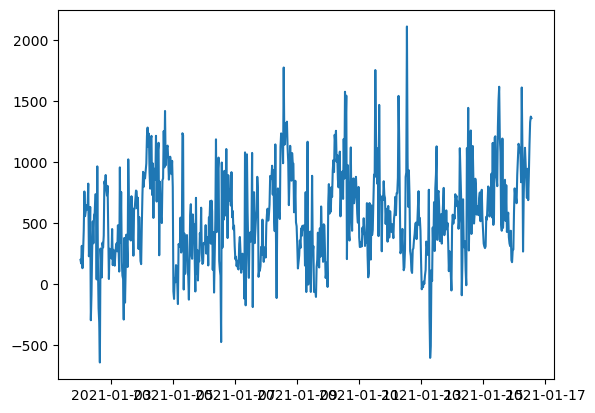

In [49]:
mdl = MultivariateNormal()
mdl.train(data)
mvn_samples = mdl.sample(data)

plt.plot(mvn_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['times'][:700].T, mvn_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['samples'][:700].T)
print(len(mvn_samples['/001dce72-b1c1-44b1-bf16-0c22cfe3a420']['samples']))

# Define Metrics & Evaluation Tools

- still the using the older version (the a little below) of the MMD (April 2023) as a newer implementation (latest Ben, below) produced errors for me

In [ ]:
# # MMD score latest; by Ben
# def mmd(x_real: torch.Tensor, x_fake: torch.Tensor):
#     """
#     Calculates the Maximum-Mean-Discrepancy between two tensors, using the (optimal) bandwidth calculated below;
#     and a Gaussian kernel.
#     Args:
#         x_real: tensor of (real) data of shape [n_samples, n_features, seq_len]
#         x_fake: tensor of (dake) data of shape [n_samples, n_features, seq_len]
#     """
#     n_1, f_1, seq_1 = x_real.shape
#     n_2, f_2, seq_2 = x_fake.shape
#     x_real = x_real.reshape(n_1, f_1 * seq_1).cpu()
#     x_fake = x_fake.reshape(n_2, f_2 * seq_2).cpu()

#     sigma = optim_bw_mmd(x_real, x_fake)

#     xy = torch.cat([x_real, x_fake], dim=0)  # concatenate: new size [n_1+n_2,-1]
#     distances = torch.cdist(xy, xy, p=2)  # pairwise distances in L^2
#     k = torch.exp(
#         -(distances ** 2) / (2 * sigma ** 2))  # + epsilon * torch.eye(n_1 + n_2)  # 2. for numerical stability
#     k_x = k[:n_1, :n_1]
#     k_y = k[n_1:, n_1:]
#     k_xy = k[:n_1, n_1:]

#     mmd_score = k_x.sum() / (n_1 * (n_1 - 1)) + k_y.sum() / (n_2 * (n_2 - 1)) - 2 * k_xy.sum() / (n_1 * n_2)

#     return mmd_score


# def optim_bw_mmd(x_real, x_fake):
#     """
#     Finds the optimal bandwidth for calculating the MMD score.
#     """
#     n_1 = len(x_real)
#     n_2 = len(x_fake)
#     x_real = x_real.view(n_1, -1)
#     x_fake = x_fake.view(n_2, -1)

#     distances = torch.pdist(torch.cat([x_real, x_fake], dim=0))
#     indx = np.random.permutation(len(distances))[:500]
#     sigma = distances[indx].median() / 2

#     return sigma

# def rbf_kernel_dist(dist, sigma):
#     return torch.exp(- torch.square(dist) / (2*torch.square(sigma)))

# def new_mmd(x:torch.Tensor, y:torch.Tensor, device:str):
#     """
#     Calculates the Maximum-Mean-Discrepancy between two tensors, using the (optimal) bandwidth calculated below;
#     and a Gaussian kernel.
#     Implemented as in 'A kernel method for the two-sample problem', Gretton et. al. (2012)
#     Args:
#         X: tensor of (real) data of shape [n1_samples, seq_len]
#         Y: tensor of (fake) data of shape [n2_samples, seq_len]
#         device: string of the device i.e. 'cpu' for cpu, 'cuda' for gpu, 'cuda:1' for gpu 2 etc.
#     """
#     x = x.to(device)
#     y = y.to(device)
#     x_dist = torch.pdist(x).flatten()
#     y_dist = torch.pdist(y).flatten()
#     xy_dist = torch.cdist(x,y).flatten()
#     full_dists = torch.cat([x_dist, y_dist, xy_dist]).cpu()
#     sigma = full_dists.median().unsqueeze(0).to(device)
#     m = x.shape[0]
#     n = y.shape[0]

#     x_kernels = rbf_kernel_dist(x_dist, sigma)
#     y_kernels = rbf_kernel_dist(y_dist, sigma)
#     xy_kernels = rbf_kernel_dist(xy_dist, sigma)

#     return (torch.sum(x_kernels)*2/(m*(m-1)) -  2 * torch.sum(xy_kernels) / (m*n) + torch.sum(y_kernels)*2/(n*(n-1))).item()


In [51]:
# Maximum-Mean-Discrepancy
def mmd(x_real, x_fake):
    """
    Calculates the Maximum-Mean-Discrepancy between two tensors, using the (optimal) bandwidth calculated below;
    and a Gaussian kernel.
    Args:
        x_real: tensor of (real) data of shape [n_samples, n_features, seq_len]
        x_fake: tensor of (fake) data of shape [n_samples, n_features, seq_len]
    """

    if (len(x_real.shape)==3):
      n_1, f_1, seq_1 = x_real.shape
      n_2, f_2, seq_2 = x_fake.shape
      x_real = x_real.reshape(n_1, f_1 * seq_1)
      x_fake = x_fake.reshape(n_2, f_2 * seq_2)
    elif (len(x_real.shape)==2):
      n_1, seq_1 = x_real.shape
      n_2, seq_2 = x_fake.shape
    else:
      raise ValueError("Only 2 or 3 dimensional tensors are possible.")

    sigma = optim_bw_mmd(x_real, x_fake)

    xy = np.concatenate([x_real, x_fake], axis=0)  # concatenate: new size [n_1+n_2,-1]
    #print(xy.shape)
    distances = cdist(xy, xy); #torch.cdist(xy, xy, p=2)  # pairwise distances in L^2
    k = np.exp(
        -(distances ** 2) / (2 * sigma ** 2))  # + epsilon * torch.eye(n_1 + n_2)  # 2. for numerical stability
    k_x = k[:n_1, :n_1]
    k_y = k[n_1:, n_1:]
    k_xy = k[:n_1, n_1:]

    mmd_score = k_x.sum() / (n_1 * (n_1 - 1)) + k_y.sum() / (n_2 * (n_2 - 1)) - 2 * k_xy.sum() / (n_1 * n_2)

    return mmd_score

def optim_bw_mmd(x_real, x_fake):
    """
    Finds the optimal bandwidth for calculating the MMD score.
    """
    n_1 = len(x_real)
    n_2 = len(x_fake)
    x_real = x_real.reshape(n_1, -1)
    x_fake = x_fake.reshape(n_2, -1)

    distances = pdist(np.concatenate([x_real, x_fake], axis=0))
    #indx = np.random.permutation(len(distances))[:500]
    indx = np.arange(len(distances))
    sigma = np.median(distances[indx]) / 2

    return sigma


def compute_household_mmd(data, **kwargs):
  results = {mdl_name: [] for mdl_name in kwargs.keys()}
  for household in tqdm(data):
    time_test, power_test = household['time_test'], household['power_test']
    key = household['key']
    X_test = timeseries_to_day_matrix(time_test, power_test)
    for mdl_name, samples in kwargs.items():
      time_fake = samples[key]['times']
      power_fake = samples[key]['samples']
      X_fake = timeseries_to_day_matrix(time_fake, power_fake)
      mmd_value = mmd(X_fake, X_test)
      results[mdl_name].append(mmd_value)
      
  return results


household_mmds = compute_household_mmd(data,
  DDPM=ddpm_samples,
)

100%|██████████| 459/459 [00:35<00:00, 13.06it/s]


KeyError: 'BASELINE'

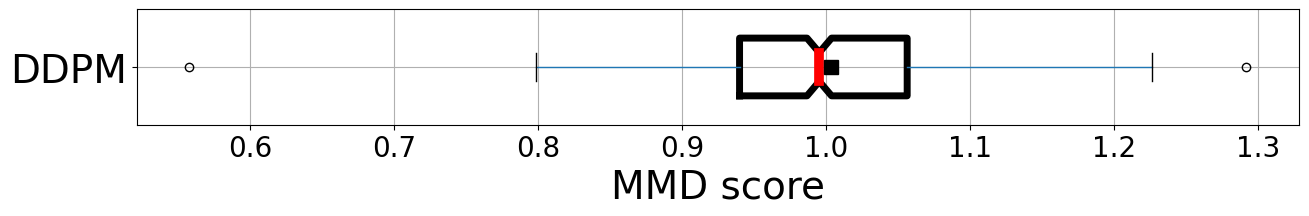

In [52]:
def boxplot_day_mmd(results, baseline_mdl):  
  results_df = pd.DataFrame(results)
  plt.figure(figsize=(15,1.5*len(results.keys())))
  results_df.boxplot(vert=False, notch=True, showmeans=True, meanprops=dict(marker='s', markersize=10, markerfacecolor='black', markeredgecolor='black'), medianprops=dict(linewidth=7, color='red'), widths=0.5, boxprops= dict(linewidth=5))
  plt.xlabel('MMD score', fontsize=28)
  plt.yticks(fontsize=28)
  plt.xticks(fontsize=20)

  for k, mdl_name in enumerate(results.keys()):
    pairwise_differences = np.array(results[baseline_mdl]) - np.array(results[mdl_name])
    if mdl_name != baseline_mdl:
      test_results = scipy.stats.ttest_1samp(pairwise_differences.ravel(), 0, alternative='two-sided')
      plt.text(1, k+0.6, f'p-value = {test_results.pvalue:e<0.3}', fontsize=22)
    else:
      plt.text(1, k+0.6, f'Baseline', fontsize=22)
  #plt.title(f'Boxplot and p-Values of Pairwise two-sided t-Test', fontsize=16)

boxplot_day_mmd(household_mmds, baseline_mdl='BASELINE')


## Diurnal plots

- some weird behavior going on here.

- I tried to replicate the loading part above so that the rest of the Analysis would work like for the LSM-challenge (April 24)

- the samples however, don't really work out here, as my later plor shows quit good results, the plots here are all over the place
    - *thats why I dont't really trust the later UMAP-results really*
        - *my guess would be, that I messed something up during the sample-generation before*

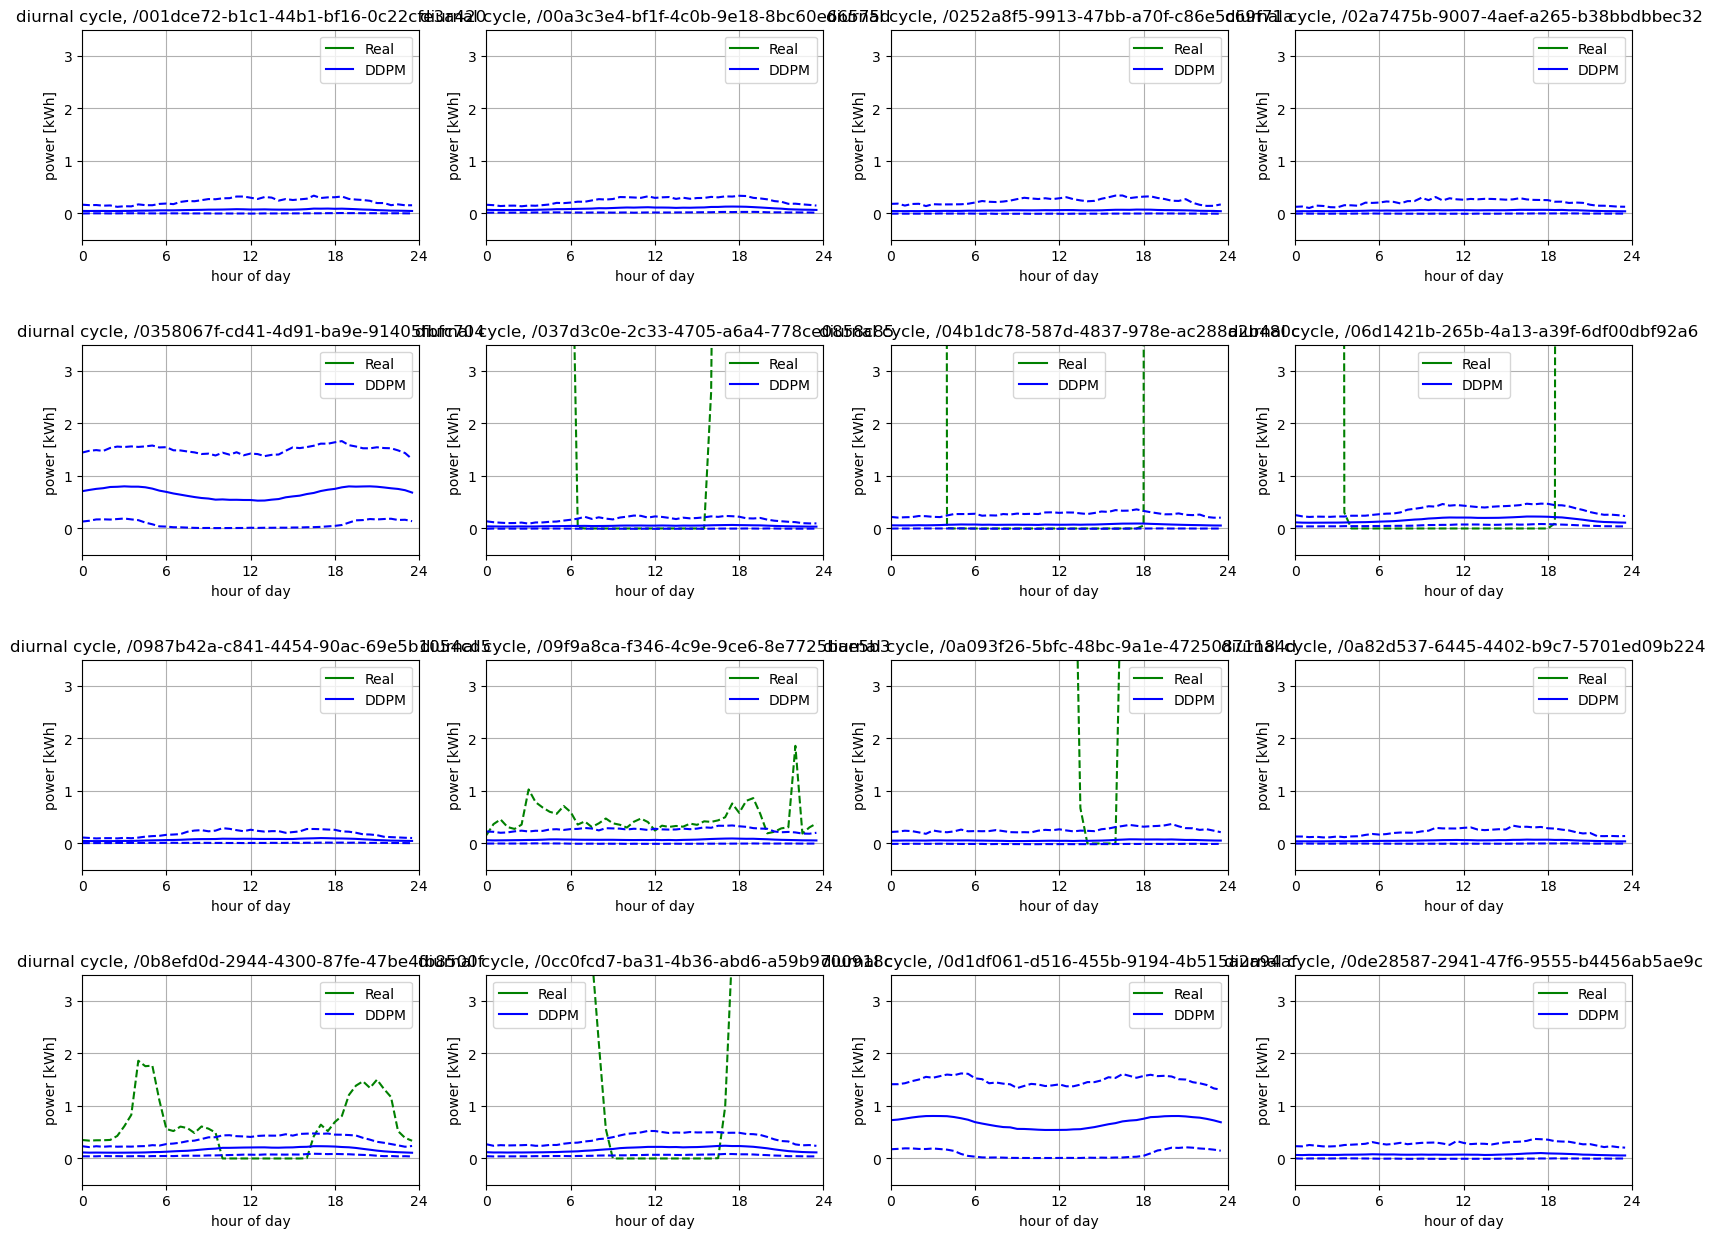

In [54]:
def diurnal_average_plot(data, samples, mdl_name):
  plt.figure(figsize=(20,15))

  for k, household in enumerate(data):
    if k>15:
      break
    time_test, power_test = household['time_test'], household['power_test']
    key = household['key']

    X_test = timeseries_to_day_matrix(time_test, power_test)

    time_fake = samples[key]['times']
    power_fake = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(time_fake, power_fake)

    mean_day_test = np.mean(X_test, axis=0)
    mean_day_mvn = np.mean(X_fake, axis=0)

    prctl_test = np.percentile(X_test, q=[5, 95], axis=0)
    prctl_mvn = np.percentile(X_fake, q=[5, 95], axis=0)

    hour = np.arange(0, 24, step=0.5)
    plt.subplot(4, 4, k+1)
    plt.plot(hour, mean_day_test, 'g', label='Real')
    plt.plot(hour, prctl_test.T, 'g--')
    plt.plot(hour, mean_day_mvn, 'b', label=mdl_name)
    plt.plot(hour, prctl_mvn.T, 'b--')
    plt.xticks([0,6,12,18,24])
    plt.legend()
    plt.xlabel('hour of day')
    plt.title(f'diurnal cycle, {key}')
    plt.ylabel('power [kWh]')
    plt.grid('on')
    plt.xlim([0, 24])
    plt.ylim([-.5, 3.5])
  plt.subplots_adjust(hspace=0.5)
  plt.show()

# diurnal_average_plot(data, gmm_samples, mdl_name='GMM')
# print("\n"*1)
# diurnal_average_plot(data, mvn_samples, mdl_name='MVN')
# print("\n"*1)
# diurnal_average_plot(data, hmm_samples, mdl_name='HMM')
# print("\n"*1)
diurnal_average_plot(data, ddpm_samples, mdl_name='DDPM')
print("\n"*1)
# diurnal_average_plot(data, con_bnf_samples, mdl_name='con_BNF')
# print("\n"*1)
# diurnal_average_plot(data, con_bnf_samples2, mdl_name='con_MAF_BNF')
# print("\n"*1)
# diurnal_average_plot(data, CNN_VAE_samples, mdl_name='CNN_VAE')
# print("\n"*1)
#diurnal_average_plot(data, WGAN_samples, mdl_name='WGAN')

- I would say that the violin-plots are also "bullshit" due to badly prepared samples; thus cannor really interpreted

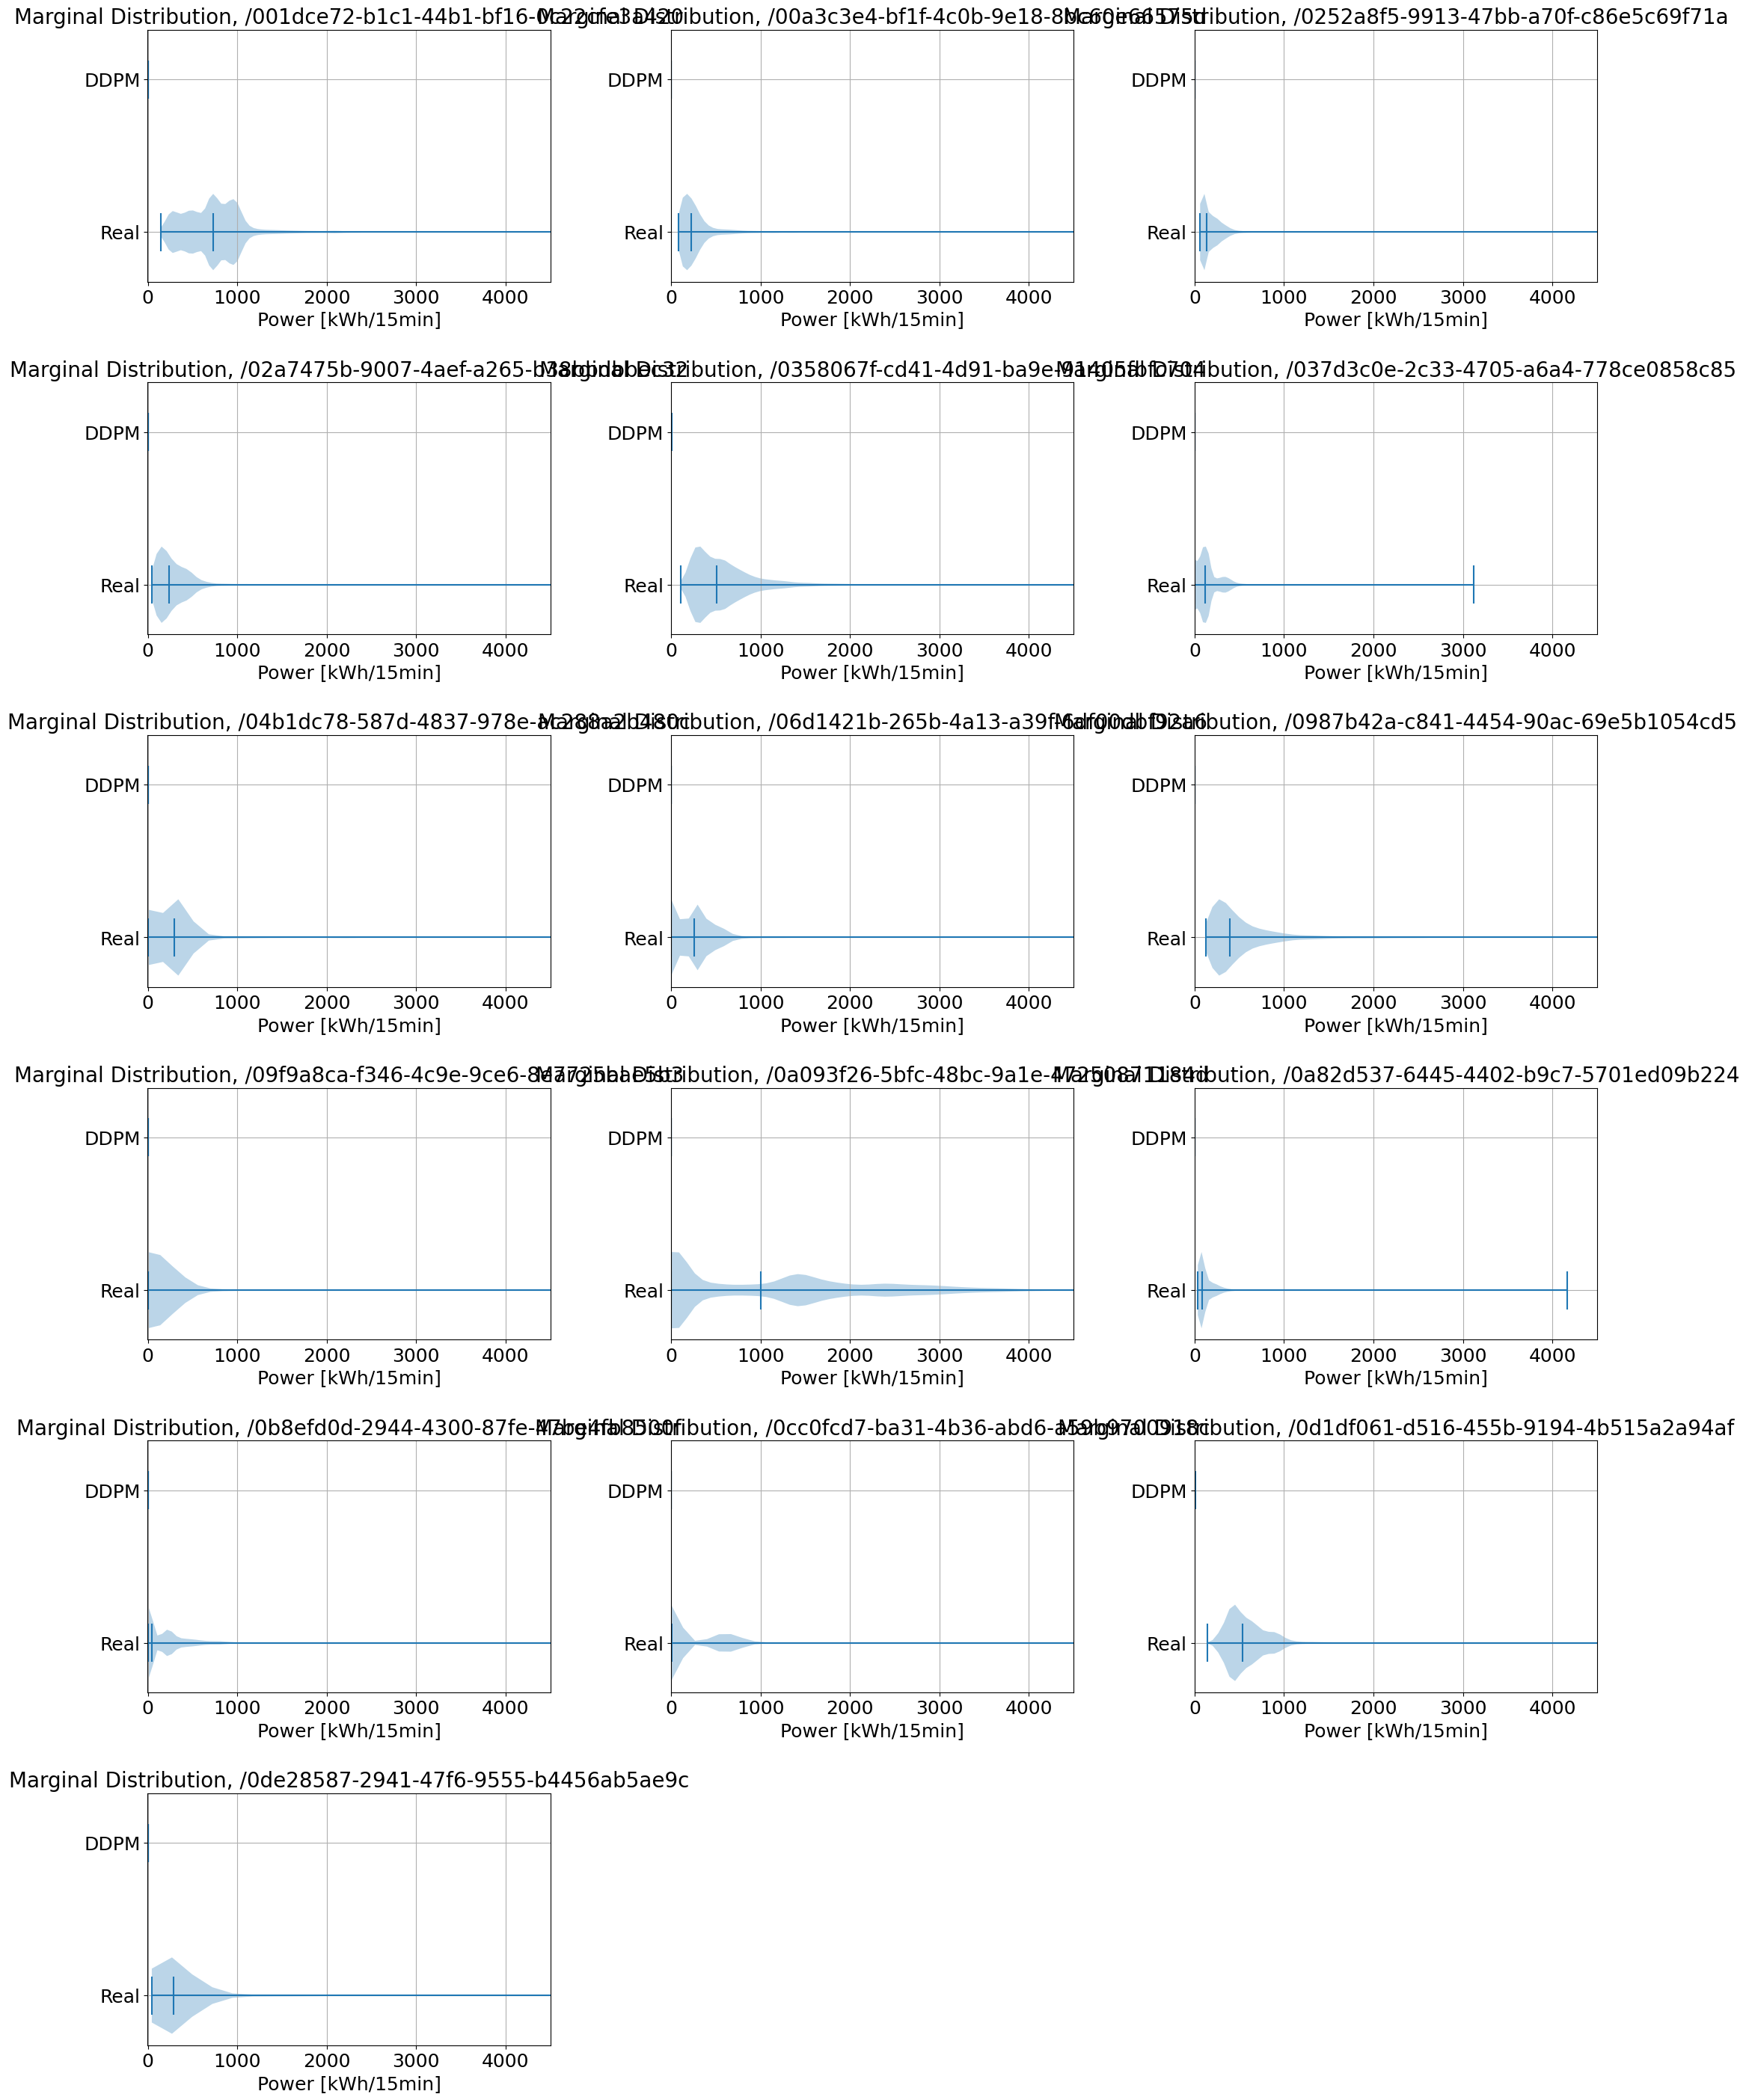

In [58]:

def marginal_dist_violinplots(data, **model_samples):
  plt.figure(figsize=(25,35))
  
  for k, household in enumerate(data):
    if k>=16:
      break
    plt.subplot(6, 3, k+1)
    key = household['key']
    data_list = [household['power_test']]
    label_list = ['Real']
    for mdl_name, samples in model_samples.items():
      data_list.append(samples[key]['samples'])
      label_list.append(mdl_name)
    plt.violinplot(data_list, 
                  showmeans=False, 
                  showmedians=True, 
                  showextrema=True, 
                  vert=False)
    ticks = np.arange(1, len(label_list)+1)
    plt.yticks(ticks, label_list, rotation=0, fontsize=18)
    plt.xlabel('Power [kWh/15min]', fontsize=18)
    plt.xlim([-1.2, 4500])
    plt.xticks(fontsize=18)
    plt.title(f'Marginal Distribution, {key}', fontsize=20)
    plt.grid('on')
  plt.subplots_adjust(hspace=0.4)
  plt.subplots_adjust(wspace=0.3)
  plt.show()


marginal_dist_violinplots(data, 
  # GMM=gmm_samples, 
  # MVN=mvn_samples,
  # HMM=hmm_samples,
  # BNF=con_bnf_samples,
  # MAF_BNF=con_bnf_samples2,
  DDPM=ddpm_samples,
  #CNN_VAE=CNN_VAE_samples,
  #WGAN=WGAN_samples  
)

- same here. The Clustering looks way worse than what I would expect from the data-traces

(5450,)
(5450, 48)


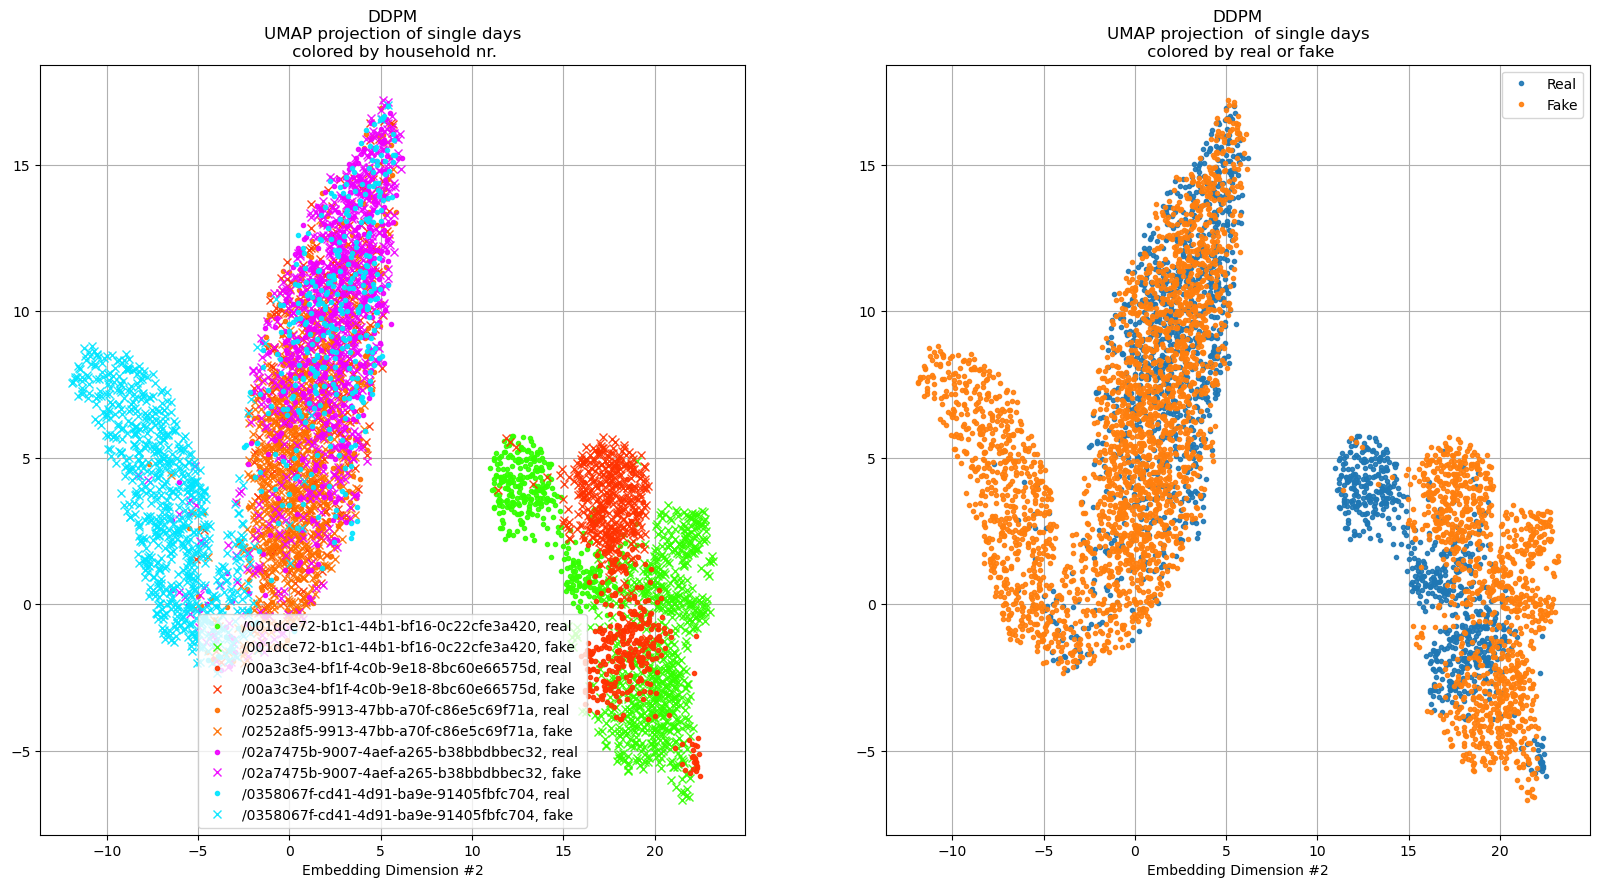

In [59]:
def umap_plots(data, samples, mdl_name, n_households=5):

  X_real_list = []
  X_fake_list = []

  id_list = []
  fake_flag = []
  key_list = []
  for k, household in enumerate(data):
    if k>=n_households:
      break
    real_time = household['time_test']
    real_power = household['power_test']
    key = household['key']

    key_list.append(key)

    X_real = timeseries_to_day_matrix(real_time, real_power)
    X_real_list.append(X_real)

    fake_time = samples[key]['times']
    fake_power = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(fake_time, fake_power)
    X_fake_list.append(X_fake)

    id = np.ones(X_real.shape[0] + X_fake.shape[0])*k
    id_list.append(id)

    fake = np.ones(X_real.shape[0] + X_fake.shape[0])
    fake[:X_real.shape[0]] = 0
    fake_flag.append(fake)
    

  id_list = np.concatenate(id_list)
  fake_flag = np.concatenate(fake_flag)

  X_real_all = np.concatenate(X_real_list, axis=0)
  X_fake_all = np.concatenate(X_fake_list, axis=0)

  X_all = np.concatenate([X_real_all, X_fake_all], axis=0);


  print(id_list.shape)
  print(X_all.shape)

  # standardize columns
  mean_all = np.mean(X_all, axis=0)
  std_all = np.std(X_all, axis=0)
  X_all = (X_all-mean_all)/std_all

  # Define UMAP parameters
  n_components = 2
  n_neighbors = 10
  min_dist = 1.

  # Create a UMAP model and fit the data
  umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
  umap_data = umap_model.fit_transform(X_all)

  # Plot the results
  plt.figure(figsize=(20,10))
  plt.subplot(1,2,1)
  for k, key in enumerate(key_list):
    color = np.random.rand(3)
    color = (color-color.min())/(color.max()-color.min())
    fltr = np.logical_and(id_list==k, fake_flag==0)
    plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], '.', color=color, alpha=0.9, label=f'{key}, real')
    fltr = np.logical_and(id_list==k, fake_flag==1)
    plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], 'x', color=color, alpha=0.9, label=f'{key}, fake')
  plt.legend()

  #plt.scatter(umap_data[:, 0], umap_data[:, 1], c=id_list, s=10, alpha=0.9)
  plt.grid('on')
  plt.title(f"{mdl_name}\nUMAP projection of single days\n colored by household nr.")
  plt.xlabel('Embedding Dimension #1')
  plt.xlabel('Embedding Dimension #2')

  # Plot the results
  plt.subplot(1,2,2)
  #plt.scatter(umap_data[:, 0], umap_data[:, 1], c=fake_flag, s=10, alpha=0.9)
  plt.plot(umap_data[fake_flag==0, 0], umap_data[fake_flag==0, 1], '.', alpha=0.9, label='Real')
  plt.plot(umap_data[fake_flag==1, 0], umap_data[fake_flag==1, 1], '.', alpha=0.9, label='Fake')
  plt.grid('on')
  plt.legend()
  plt.title(f"{mdl_name}\nUMAP projection  of single days\n colored by real or fake")
  plt.xlabel('Embedding Dimension #1')
  plt.xlabel('Embedding Dimension #2')

  plt.show()

# umap_plots(data, gmm_samples, mdl_name='Gaussian Mixutre Model')
# umap_plots(data, mvn_samples, mdl_name='Multivariate Normal Model')
# umap_plots(data, con_bnf_samples, mdl_name='BNF')
# umap_plots(data, con_bnf_samples2, mdl_name='MAF_BNF')
# umap_plots(data, hmm_samples, mdl_name='HMM')
umap_plots(data, ddpm_samples, mdl_name='DDPM')
# umap_plots(data, CNN_VAE_samples, mdl_name='CNN_VAE')
#umap_plots(data, WGAN_samples, mdl_name='WGAN')
#umap_plots(data, om_samples, mdl_name='OM')

(5450, 48)
(5450,)
(5450,)
(5450,)


'\numap_plots(data, \n  # GMM=gmm_samples, \n  # MVN=mvn_samples,\n  DDPM=ddpm_samples,\n  HMM=hmm_samples,\n  MAF_BNF=con_bnf_samples2,\n  BNF=con_bnf_samples,\n  VAE=CNN_VAE_samples,\n  WGAN=wgan_samples\n)\n'

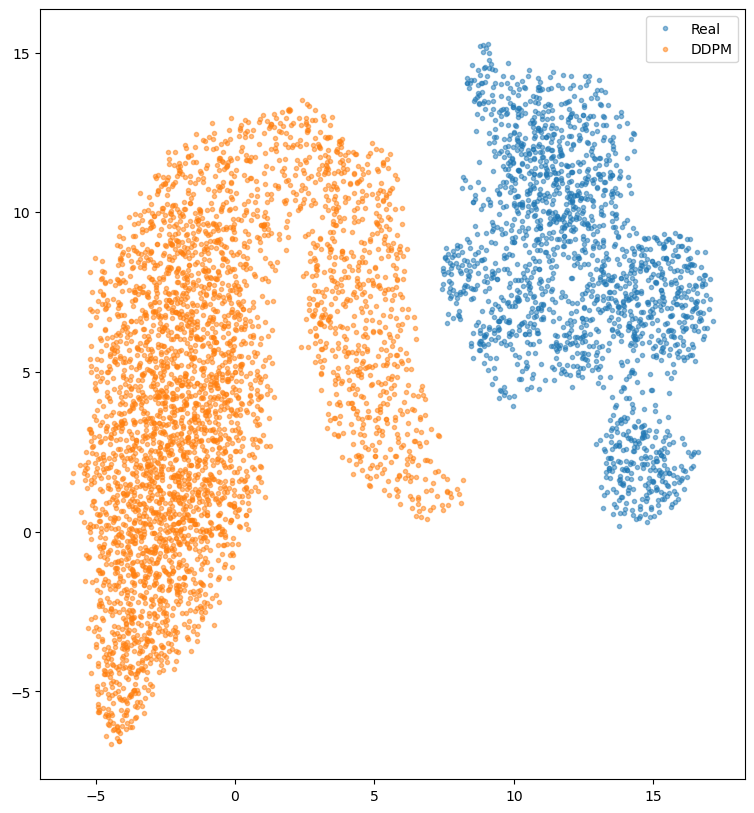

In [60]:
n_households=5
model_samples = dict(
  # GMM=gmm_samples, 
  # MVN=mvn_samples,
  # HMM=hmm_samples,
  DDPM=ddpm_samples,
  # MAF_BNF=con_bnf_samples2,
  # BNF=con_bnf_samples,
  # VAE=CNN_VAE_samples,
  #WGAN=WGAN_samples,
  #OM=om_samples
)
#def umap_plots(data, n_households=5, **model_samples):

X_list = []


household_id_list = []
fake_flag = []
key_list = []
mdl_list = []
mdl_names = ['Real']
mdl_ids = [-1]

for k, household in enumerate(data):
  if k>=n_households:
    break
  real_time = household['time_test']
  real_power = household['power_test']
  key = household['key']

  key_list.append(key)

  X_real = timeseries_to_day_matrix(real_time, real_power)
  X_list.append(X_real)

  household_id = np.ones(X_real.shape[0])*k
  household_id_list.append(household_id)
  fake = np.ones(X_real.shape[0])
  fake_flag.append(fake)
  mdl_list.extend([-1]*X_real.shape[0])
  for mdl_id, (mdl_name, samples) in enumerate(model_samples.items()):
    fake_time = samples[key]['times']
    fake_power = samples[key]['samples']
    X_fake = timeseries_to_day_matrix(fake_time, fake_power)
    X_list.append(X_fake)

    household_id = np.ones(X_fake.shape[0])*k
    household_id_list.append(household_id)
    fake = np.zeros(X_fake.shape[0])
    fake_flag.append(fake)
    mdl_list.extend([mdl_id]*X_fake.shape[0])
    if k==0:
      mdl_ids.append(mdl_id)
      mdl_names.append(mdl_name)

household_id_list = np.concatenate(household_id_list)
fake_flag = np.concatenate(fake_flag)
mdl_list = np.array(mdl_list)

X_all = np.concatenate(X_list, axis=0)

print(X_all.shape)
print(mdl_list.shape)
print(fake_flag.shape)
print(household_id_list.shape)

# standardize columns
mean_all = np.mean(X_all, axis=0)
std_all = np.std(X_all, axis=0)
X_all = (X_all-mean_all)/std_all

# Define UMAP parameters
n_components = 2
n_neighbors = 10
min_dist = 1.

# Create a UMAP model and fit the data
umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist)
umap_data = umap_model.fit_transform(X_all)

# Plot the results
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
for k, (mdl_id, mdl_name) in enumerate(zip(mdl_ids, mdl_names)):
  fltr = mdl_list==mdl_id
  plt.plot(umap_data[fltr, 0], umap_data[fltr, 1], '.', alpha=0.5, label=f'{mdl_name}')
plt.legend()

"""
umap_plots(data, 
  # GMM=gmm_samples, 
  # MVN=mvn_samples,
  DDPM=ddpm_samples,
  HMM=hmm_samples,
  MAF_BNF=con_bnf_samples2,
  BNF=con_bnf_samples,
  VAE=CNN_VAE_samples,
  WGAN=wgan_samples
)
"""

## Neighbour 24h plot of samples from UMAP

- the single Traces here confirm more or less that the samples even from the original Data look kind of bad

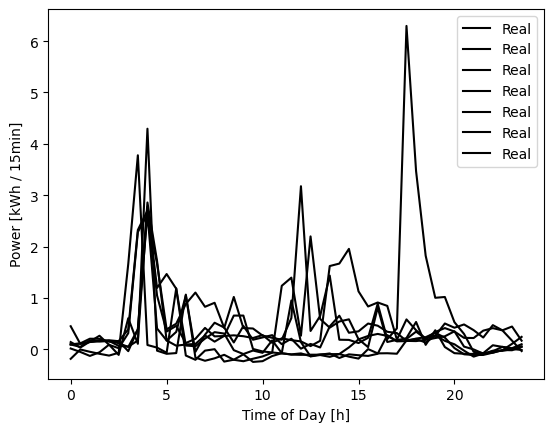

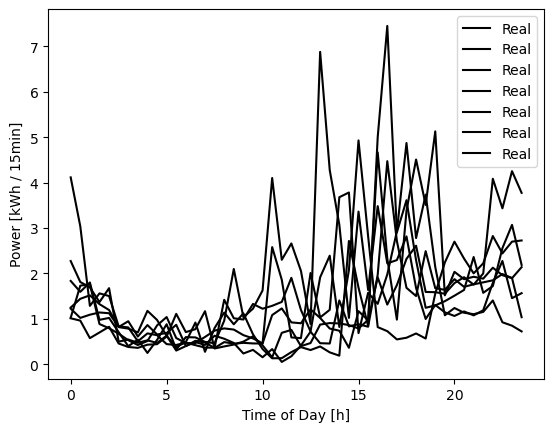

In [64]:
def plot_neighbors(umap_data, target_position, n = 10):
  target_position = np.array(target_position).reshape(1,2)
  idx_sort = np.argsort(np.sum(np.square(umap_data - target_position), axis=1))
  target_samples = X_all[idx_sort[:n]]
  target_mdls = mdl_list[idx_sort[:n]]

  color_list = ['k', 'r', 'b', 'orange']
  for ts, tmdls in zip(target_samples, target_mdls):
    plt.plot(np.arange(0, 24, 0.5), ts, color_list[tmdls+1], label=mdl_names[tmdls+1])
  plt.legend()
  plt.xlabel('Time of Day [h]')
  plt.ylabel('Power [kWh / 15min]')
  

plot_neighbors(umap_data, [9, 7], n = 7)
plt.show()

plot_neighbors(umap_data, [15, 7.5], n = 7)
plt.show()

In [62]:
umap_data.shape

(5450, 2)

c:\Users\Nikita\anaconda3\envs\DeepKALE\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


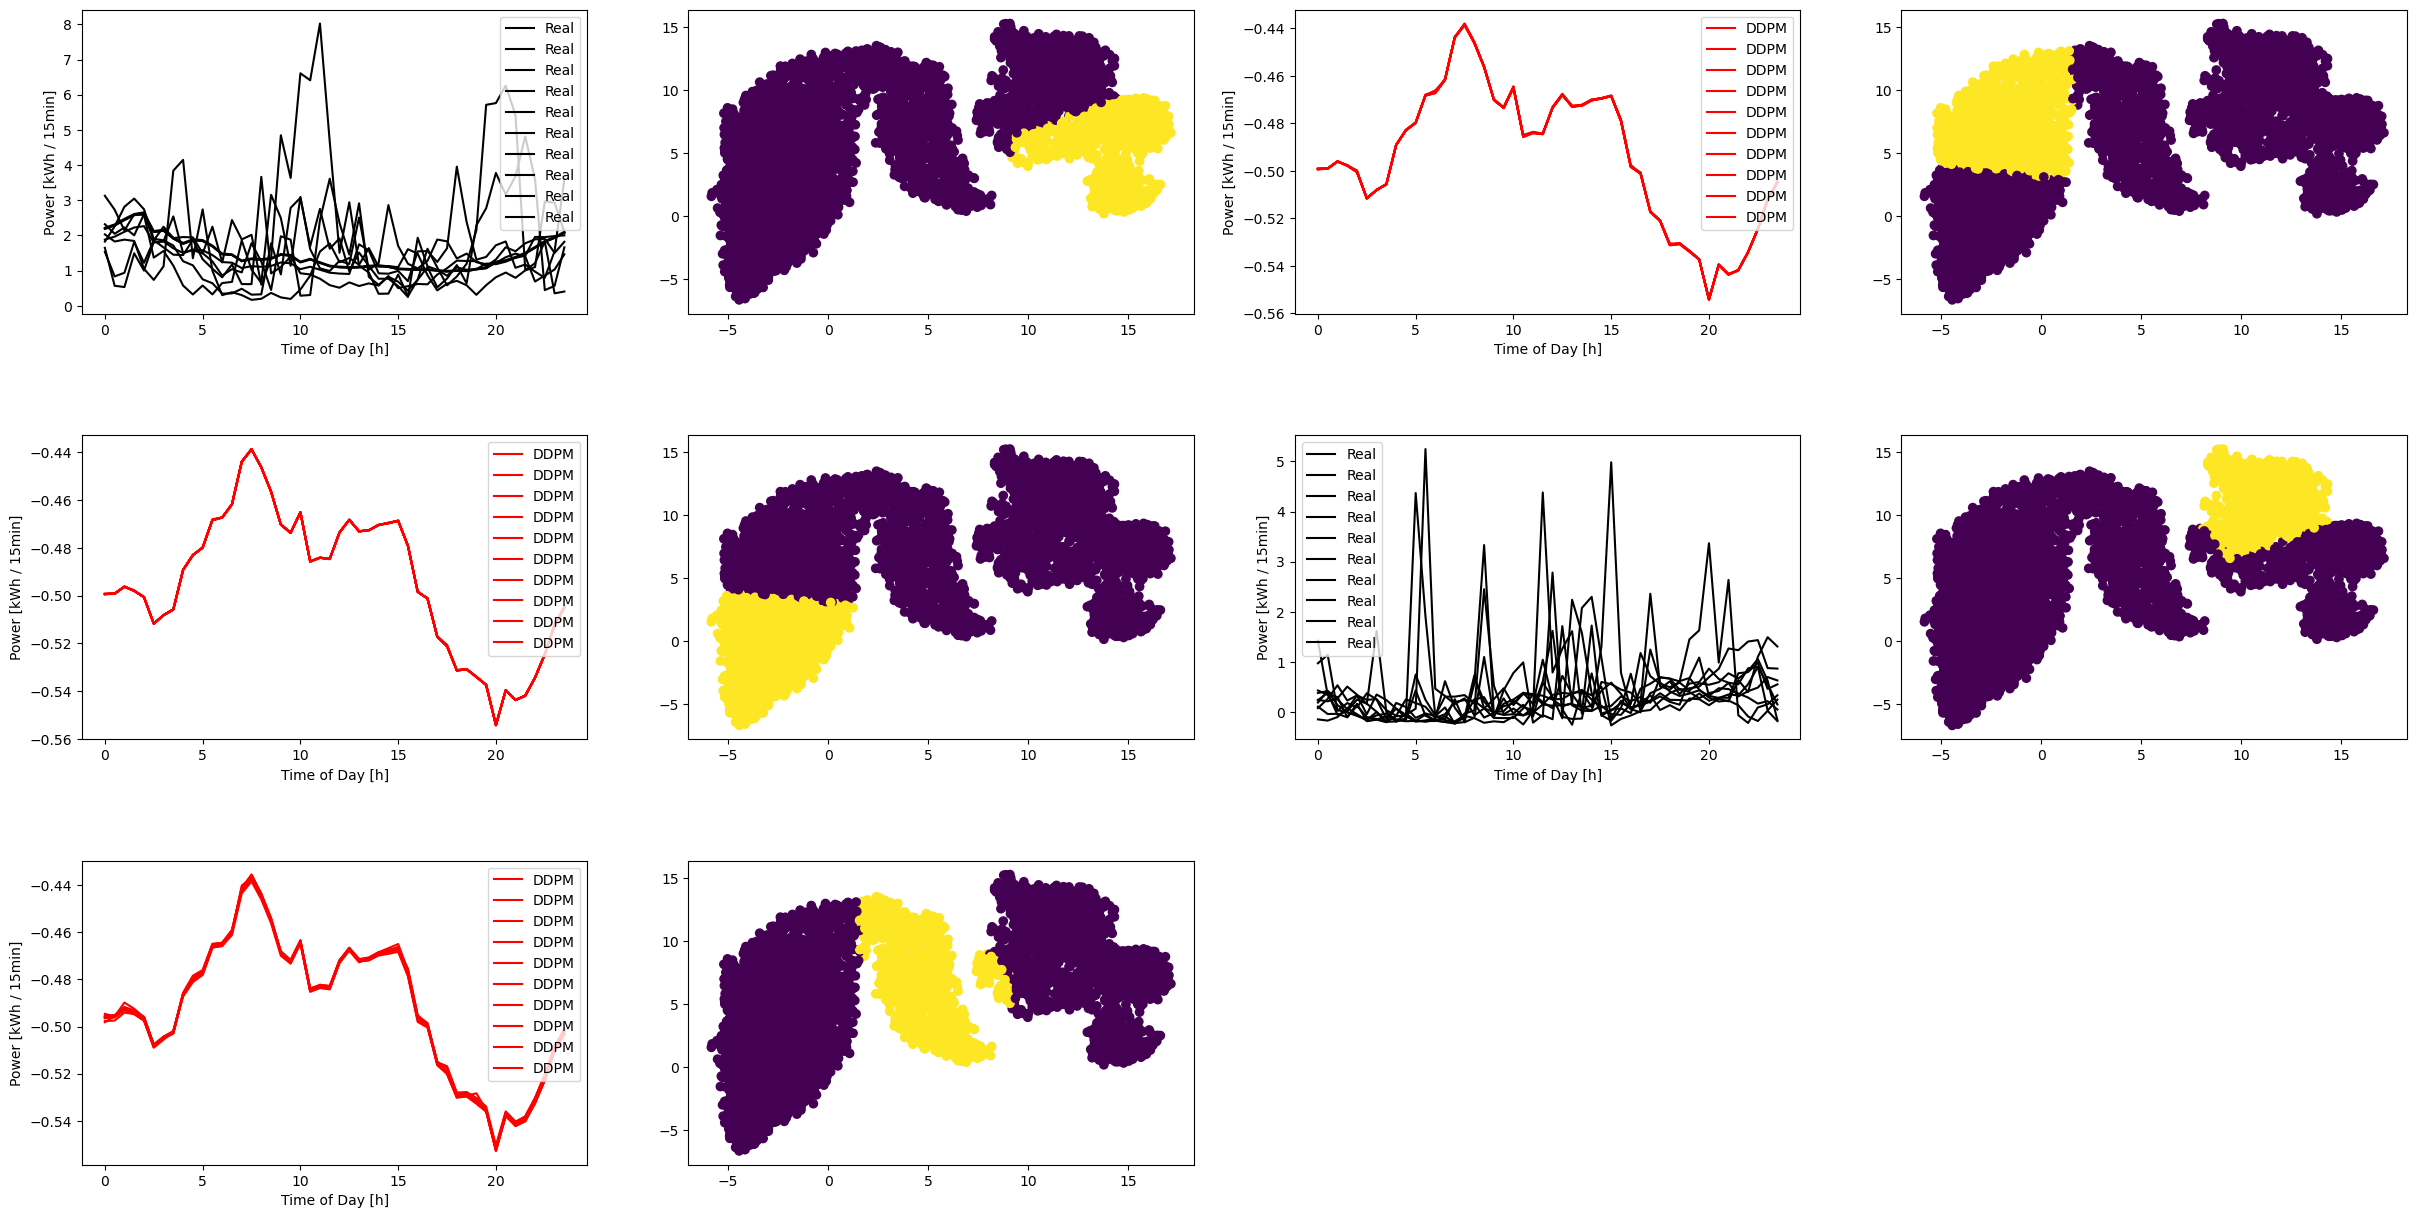

In [65]:
n_clusters = 5
kmeans_mdl = KMeans(n_clusters=n_clusters)
kmeans_mdl.fit(umap_data)
cluster_id = kmeans_mdl.predict(umap_data)

plt.figure(figsize=(30, 15))
for k, center in enumerate(kmeans_mdl.cluster_centers_):
  #plt.subplot(1, 4, 2*k+1)
  plt.subplot(3, 4, 2*k+1)
  plot_neighbors(umap_data, center, n = 10)

  plt.subplot(3, 4, 2*k+2)
  plt.scatter(umap_data[:,0], umap_data[:,1], c=cluster_id == k)
plt.subplots_adjust(hspace=0.4)

# Daily avg and 95% CI 

In [66]:
column_headers = om_df.columns.T
sensorIDs_df = pd.DataFrame(columns=column_headers).transpose()
sensorIDs_df = sensorIDs_df.reset_index()

In [ ]:
#sensorIDs_df

In [ ]:
#ddpm_df

# Single position as changing parameter

To quickly plot single IDs for 24h averages I grabbed the Sensor_IDs from the headers of om_df

Now we can use simply an index 1-444 for the profiles we have to avoid those long sensor-IDs

In [67]:
# single_pos = 222
single_pos = 337


In [68]:
single_id = sensorIDs_df.iloc[single_pos,0]

single_df = om_df[['Datetime', single_id]].copy()
single_df['Datetime'] = pd.to_datetime(single_df['Datetime'])

# temp_df[ddpm] = ddpm_df[[single_id]].copy()
temp_df = ddpm_df[['Datetime', single_id]].copy()
temp_df['Datetime'] = pd.to_datetime(temp_df['Datetime'])

single_df = pd.merge(single_df, temp_df, on='Datetime', how='inner')

temp_df = WGAN_df[['Datetime', single_id]].copy()
temp_df['Datetime'] = pd.to_datetime(temp_df['Datetime'])

single_df = pd.merge(single_df, temp_df, on='Datetime', how='inner')

column_name = single_df.columns[1]
single_df = single_df.rename(columns={column_name: 'raw'})

column_name = single_df.columns[2]
single_df = single_df.rename(columns={column_name: 'ddpm'})

column_name = single_df.columns[3]
single_df = single_df.rename(columns={column_name: 'WGAN'})


single_df['DayOfWeek'] = single_df['Datetime'].dt.dayofweek

# Create a time column in minutes past midnight
single_df['Time'] = single_df['Datetime'].dt.hour * 60 + single_df['Datetime'].dt.minute

days_of_week = sorted(single_df['DayOfWeek'].unique())

day_names = [calendar.day_name[day] for day in days_of_week]


KeyError: "['Datetime'] not in index"

In [ ]:
#single_df

In [ ]:
# Group data by 'DayOfWeek' and 'Time'
groups = single_df.groupby(['DayOfWeek', 'Time'])

# Func to calculate the 95% CI for 'raw', 'ddpm', and 'WGAN' & return to df
def calculate_ci(data):
    mean_raw = data['raw'].mean()
    se_raw = data['raw'].sem()
    z_score = 1.96  # Z-score for a 95% CI (assuming normal distribution)
    margin_of_error_raw = z_score * se_raw
    lower_bound_raw = mean_raw - margin_of_error_raw
    upper_bound_raw = mean_raw + margin_of_error_raw

    mean_ddpm = data['ddpm'].mean()
    se_ddpm = data['ddpm'].sem()
    margin_of_error_ddpm = z_score * se_ddpm
    lower_bound_ddpm = mean_ddpm - margin_of_error_ddpm
    upper_bound_ddpm = mean_ddpm + margin_of_error_ddpm

    mean_wgan = data['WGAN'].mean()
    se_wgan = data['WGAN'].sem()
    margin_of_error_wgan = z_score * se_wgan
    lower_bound_wgan = mean_wgan - margin_of_error_wgan
    upper_bound_wgan = mean_wgan + margin_of_error_wgan

    return pd.Series({'mean_raw': mean_raw, 'lower_bound_raw': lower_bound_raw, 'upper_bound_raw': upper_bound_raw,
                      'mean_ddpm': mean_ddpm, 'lower_bound_ddpm': lower_bound_ddpm, 'upper_bound_ddpm': upper_bound_ddpm,
                      'mean_wgan': mean_wgan, 'lower_bound_wgan': lower_bound_wgan, 'upper_bound_wgan': upper_bound_wgan})

# Apply func for ci
ci_results = groups.apply(calculate_ci)

# Reset the index of df
ci_results.reset_index(inplace=True)

# Convert time to hour values for better plotting
ci_results['Time'] = ci_results['Time']/60

In [ ]:
#ci_results

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(20, 10), sharey=True, sharex=True)
fig.suptitle(f'Average power consumption per day of the week: {single_id}', fontsize=22)

plt.rcParams['font.family'] = 'Arial'

# Get the actual names of the days of the week
for i, (day, day_name) in enumerate(zip(days_of_week, day_names)):
    day_data = ci_results[ci_results['DayOfWeek'] == day]
    
    ax = axes[:, i]
    ax[0].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='#487db4',  linewidth=2.5)
    ax[0].fill_between(day_data['Time'], day_data['lower_bound_raw'], day_data['upper_bound_raw'], alpha=0.3, color='#487db4')
    ax[0].set_title(day_name, fontsize=17, fontweight='normal')
    #ax[0].legend(loc='upper left')
    ax[0].set_xticks(range(0, 25, 6))
    ax[0].set_xlim(-0.5, 24.5)
    ax[0].set_ylim(0, 1505)
    ax[0].set_yticks(range(0, 1505, 500))
    
    y_ticks_in_kW = [tick / 1000 for tick in range(0, 1505, 500)]
    ax[0].set_yticklabels(y_ticks_in_kW, fontsize=14)
    #ax[0].set_ylabel('mean power consumption (W)')
    ax[0].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
    ax[1].plot(day_data['Time'], day_data['mean_ddpm'], label='ddpm', color='teal', linewidth=2.5)
    ax[1].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='grey', linestyle='--', linewidth=3, alpha=0.99)
    ax[1].fill_between(day_data['Time'], day_data['lower_bound_ddpm'], day_data['upper_bound_ddpm'], alpha=0.3, color='teal')
    #ax[1].legend(loc='upper left')
    ax[1].set_xticks(range(0, 25, 6), fontsize=14)
    ax[1].set_xlim(-0.5, 24.5)
    ax[1].set_yticklabels(y_ticks_in_kW,fontsize=14)
    #ax[1].set_ylabel('mean power consumption (W)')
    ax[1].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
    ax[2].plot(day_data['Time'], day_data['mean_wgan'], label='WGAN', color='darkorange',  linewidth=2.5)
    ax[2].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='grey', linestyle='--', linewidth=3, alpha=0.99)
    ax[2].fill_between(day_data['Time'], day_data['lower_bound_wgan'], day_data['upper_bound_wgan'], alpha=0.3, color='darkorange')
    #ax[2].legend(loc='upper left')
    ax[2].set_xticks(range(0, 25, 6))
    ax[2].set_xlim(-0.5, 24.5)
    ax[2].set_xlabel('hour of the day',fontsize=18)
    ax[2].set_yticklabels(y_ticks_in_kW,fontsize=14)
    #ax[2].set_ylabel('mean power consumption (W)')
    ax[2].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
        # Darken the background between 0-6 and 22-24
    
    night_color = 'grey'
    salpha = 0.2
    
    ax[0].axvspan(0, 7, alpha=salpha, color=night_color)
    ax[0].axvspan(21, 24, alpha=salpha, color=night_color)
    ax[1].axvspan(0, 7, alpha=salpha, color=night_color)
    ax[1].axvspan(21, 24, alpha=salpha, color=night_color)
    ax[2].axvspan(0, 7, alpha=salpha, color=night_color)
    ax[2].axvspan(21, 24, alpha=salpha, color=night_color)
    
    if i == 0:
        #ax[0].set_ylabel('mean power consumption (W)',fontsize=13)
        ax[1].set_ylabel('mean power consumption (kW)', fontsize=20)
        #ax[2].set_ylabel('mean power consumption (W)',fontsize=13)

for ax_row in axes:
    for ax in ax_row:
        ax.set_xticklabels(ax.get_xticks(), fontsize=14)


# Adjust spacing between subplots and show the plot
plt.tight_layout()
plt.savefig(single_id+'.png', format='png')
plt.subplots_adjust(top=0.90)
plt.show()

In [ ]:
#un-optimized Graph

fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(25, 10), sharey=True)
fig.suptitle(f'Average power consumption per day of the week: {single_id}', fontsize=16)

# Get the actual names of the days of the week
for i, (day, day_name) in enumerate(zip(days_of_week, day_names)):
    day_data = ci_results[ci_results['DayOfWeek'] == day]
    
    ax = axes[:, i]
    ax[0].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='#487db4',  linewidth=2.5)
    ax[0].fill_between(day_data['Time'], day_data['lower_bound_raw'], day_data['upper_bound_raw'], alpha=0.3, color='#487db4')
    ax[0].set_title(day_name)
    ax[0].legend(loc='upper left')
    ax[0].set_xticks(range(0, 25, 6))
    ax[0].set_xlim(-0.5, 24.5)
    #ax[0].set_ylabel('mean power consumption (W)')
    ax[0].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
    ax[1].plot(day_data['Time'], day_data['mean_ddpm'], label='ddpm', color='teal', linewidth=2.5)
    ax[1].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='grey', linestyle='--', linewidth=3, alpha=0.99)
    ax[1].fill_between(day_data['Time'], day_data['lower_bound_ddpm'], day_data['upper_bound_ddpm'], alpha=0.3, color='teal')
    ax[1].legend(loc='upper left')
    ax[1].set_xticks(range(0, 25, 6))
    ax[1].set_xlim(-0.5, 24.5)
    #ax[1].set_ylabel('mean power consumption (W)')
    ax[1].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
    ax[2].plot(day_data['Time'], day_data['mean_wgan'], label='WGAN', color='orange',  linewidth=2.5)
    ax[2].plot(day_data['Time'], day_data['mean_raw'], label='raw', color='grey', linestyle='--', linewidth=3, alpha=0.99)
    ax[2].fill_between(day_data['Time'], day_data['lower_bound_wgan'], day_data['upper_bound_wgan'], alpha=0.3, color='orange')
    ax[2].legend(loc='upper left')
    ax[2].set_xticks(range(0, 25, 6))
    ax[2].set_xlim(-0.5, 24.5)
    ax[2].set_xlabel('hour of the day',fontsize=13)
    #ax[2].set_ylabel('mean power consumption (W)')
    ax[2].xaxis.set_minor_locator(plt.MultipleLocator(3))
    
        # Darken the background between 0-6 and 22-24
    ax[0].axvspan(0, 7, alpha=0.2, color='grey')
    ax[0].axvspan(21, 24, alpha=0.2, color='grey')
    ax[1].axvspan(0, 7, alpha=0.2, color='grey')
    ax[1].axvspan(21, 24, alpha=0.2, color='grey')
    ax[2].axvspan(0, 7, alpha=0.2, color='grey')
    ax[2].axvspan(21, 24, alpha=0.2, color='grey')
    
    if i == 0:
        ax[0].set_ylabel('mean power consumption (W)',fontsize=13)
        ax[1].set_ylabel('mean power consumption (W)', fontsize=13)
        ax[2].set_ylabel('mean power consumption (W)',fontsize=13)
  
# Adjust spacing between subplots and show the plot
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()